In [1]:
import copy
from datareader import get_data
from makespan import makespan, to_natural_order, get_order
from simulated_annealing import simulated_annealing
from improved_simulated_annealing import improved_simulated_annealing
from neh import neh
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator

sets = ["data.001", "data.002", "data.003", "data.004", "data.005", "data.006", "data.007", "data.008", "data.009", "data.010", "data.011", "data.021", "data.031"]

# Legenda

* **init_temp** (temperatura początkowa)  
* **final_temp** (temperatura końcowa  
* **u** (współczynnik wychładzania)  
* **cooling_fcn_type** (rodzaj funkcji schładzającej)  
  - 0: podstawowa  
  - 1: rozszerzona  
* **move_type** (rodzaj wykonywanego ruchu)  
  - 0: podstawowa opisana wersja  
  - 1: odrzucamy prawdopodobieństwo równe 1 dla nowych lepszych rozwiązań  
  - 2: rozważanie wyłącznie tych rozwiązań, których Cmax jest różne od wartości Cmax obecnego rozwiązania  
* **insert** (typ ruchu swap lub insert)  
  - 0: swap  
  - 1: insert  

# Podstawowe wywołanie skryptu

In [2]:
tasks, numb_of_machines = get_data("data.001")

# INITIAL ORDER
initial_order = get_order(tasks)
initial_makespan = makespan(initial_order, tasks, numb_of_machines)
print("[INIT] makespan: {}, time: {}" .format(initial_makespan, 0))

# NEH ORDER
neh_order, neh_time = neh(copy.deepcopy(tasks), numb_of_machines)
neh_makespan = makespan(neh_order, tasks, numb_of_machines)
print("[NEH ] makespan: {}, time: {}" .format(neh_makespan, neh_time))

# SIMULATED ANNEALING ORDER
init_temp = 5000
final_temp = 0.1
u = 0.98
cooling_fcn_type = 0
move_type = 0
insert = 0

simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
print("[ SA ] makespan: {}, time: {}" .format(simulated_annealing_makespan, sa_time))

print("-----")
print("Algorithm finished after: {} iterations" .format(iterations))
print("Initial temperature: {}" .format(init_temp))
print("Final temperature: {}" .format(final_temp))
print("u: {}" .format(u))
print("Cooling function type: {}" .format(cooling_fcn_type))
print("Move type: {}" .format(move_type))
print("-----")

print("NEH and SA Cmax difference: {}" .format(neh_makespan-simulated_annealing_makespan))

[INIT] makespan: 1448, time: 0
[NEH ] makespan: 1286, time: 6.4806220000002135
[ SA ] makespan: 1297, time: 49.13081900000016
-----
Algorithm finished after: 536 iterations
Initial temperature: 5000
Final temperature: 0.1
u: 0.98
Cooling function type: 0
Move type: 0
-----
NEH and SA Cmax difference: -11


## Wioski

* Dla parametrów dobranych "na oko" algorytm symulowanego wyżarzania radzi sobie całkiem dobrze, a otrzymana wartość Cmax nie odbiega zbytnio od wartości uzyskanej przy pomocy NEH'a.
* Przy tak ustawionych parametrach czas wykonania algorytmu SW jest znacznie dłuższy niż NEH'a.
* Algorytm symulowanego wyżarzania jest algorytmem probablistycznym, dlatego przy każdym uruchomieniu wartość Cmax może być nieco inna.

# Wpływ ruchów *insert* i *swap* na działanie algorytmu

In [3]:
insert_times = []
insert_cmax = []
swap_times = []
swap_cmax = []

for set in sets:
    
    tasks, numb_of_machines = get_data(set)
    
    # for SWAP move
    insert = 0
    
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    swap_times.append(sa_time)
    swap_cmax.append(simulated_annealing_makespan)
    
    # for INSERT move
    insert = 1
    
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    insert_times.append(sa_time)
    insert_cmax.append(simulated_annealing_makespan)

d = {'INSERT TIMES': insert_times, 'SWAP TIMES': swap_times, 'INSERT CMAX': insert_cmax, 'SWAP CMAX': swap_cmax}
table = pd.DataFrame(data=d)

print("Average INSERT TIMES: {}" .format(np.mean(insert_times)))
print("Average SWAP TIMES: {}" .format(np.mean(swap_times)))
print("Average INSERT CMAX: {}" .format(np.mean(insert_cmax)))
print("Average SWAP CMAX: {}" .format(np.mean(swap_cmax)))

table

Average INSERT TIMES: 59.782770153846286
Average SWAP TIMES: 61.74274361538463
Average INSERT CMAX: 1506.2307692307693
Average SWAP CMAX: 1521.0


,INSERT TIMES,SWAP TIMES,INSERT CMAX,SWAP CMAX
0,46.080476,59.355449,1297,1324
1,46.098371,48.019030,1370,1397
2,46.101922,47.541926,1147,1132
3,45.448354,45.944187,1398,1424
4,47.542927,45.649742,1338,1277
5,46.211229,45.629969,1228,1243
6,45.464950,47.469562,1298,1264
7,45.429332,45.757563,1269,1283
8,45.268004,45.416700,1258,1309
9,45.733910,46.364895,1150,1196


## Wnioski

* Zmiana wyboru między ruchem typu *insert* a *swap* praktycznie nie wpływa na czas wykonania algorytmu i otrzymane Cmaxy.

# Wpływ współczynnika wychładzania na działanie algorytmu

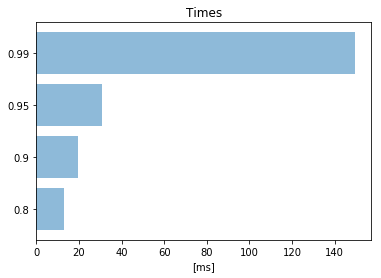

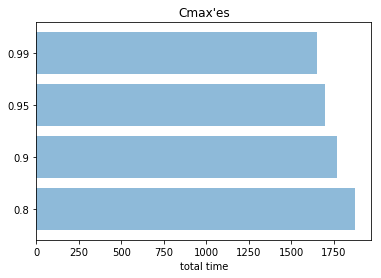

In [4]:
tasks, numb_of_machines = get_data("data.011")
us = [0.8, 0.9, 0.95, 0.99]

insert = 0

times = []
cmaxes = []

for u in us:
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    times.append(sa_time)
    cmaxes.append(simulated_annealing_makespan)

objects = ('0.8', '0.9', '0.95', '0.99')
y_pos = np.arange(len(times))

# times
plt.barh(y_pos, times, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('[ms]')
plt.title('Times')
plt.show()

# cmaxes
plt.barh(y_pos, cmaxes, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('total time')
plt.title('Cmax\'es')
 
plt.show()

## Wnioski

* Wraz ze wzrostem współczynnika wychładzania całkowity czas wykonania wszystkich zadań (Cmax) maleje, jednak kosztem wydłużenia się czasu wykonania algorytmu.

# Wpływ doboru temperatury początkowej i końcowej na działanie algorytmu

## Temperatura początkowa

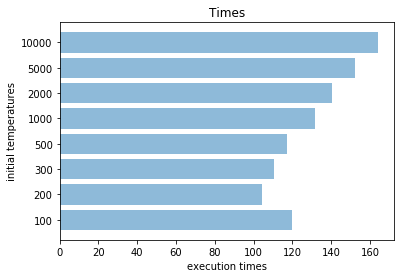

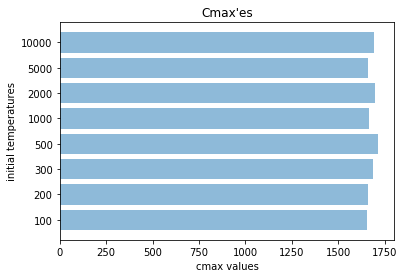

In [5]:
initial_temps = [100, 200, 300, 500, 1000, 2000, 5000, 10000]

times = []
cmaxes = []

for temp in initial_temps:
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    times.append(sa_time)
    cmaxes.append(simulated_annealing_makespan)

y_pos = np.arange(len(times))
plt.barh(y_pos, times, align='center', alpha=0.5)
plt.yticks(y_pos, initial_temps)
plt.xlabel('execution times')
plt.ylabel('initial temperatures')
plt.title('Times')
plt.show()

y_pos = np.arange(len(times))
plt.barh(y_pos, cmaxes, align='center', alpha=0.5)
plt.yticks(y_pos, initial_temps)
plt.xlabel('cmax values')
plt.ylabel('initial temperatures')
plt.title('Cmax\'es')
plt.show()

## Temperatura końcowa

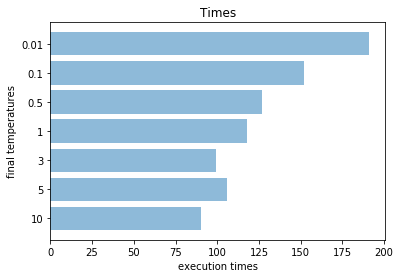

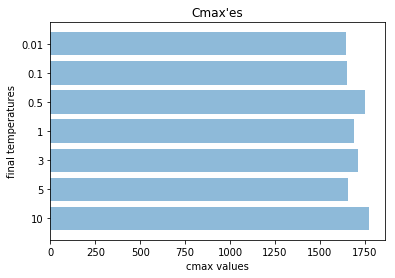

In [6]:
initial_temp = 1000
final_temps = [10, 5, 3, 1, 0.5, 0.1, 0.01]

times = []
cmaxes = []

for temp in final_temps:
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, initial_temp, temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    times.append(sa_time)
    cmaxes.append(simulated_annealing_makespan)

y_pos = np.arange(len(times))
plt.barh(y_pos, times, align='center', alpha=0.5)
plt.yticks(y_pos, final_temps)
plt.xlabel('execution times')
plt.ylabel('final temperatures')
plt.title('Times')
plt.show()

y_pos = np.arange(len(times))
plt.barh(y_pos, cmaxes, align='center', alpha=0.5)
plt.yticks(y_pos, final_temps)
plt.xlabel('cmax values')
plt.ylabel('final temperatures')
plt.title('Cmax\'es')
plt.show()

## Wnioski

* Im większa temperatura początkowa, tym większa liczba iteracji, a co za tym idzie - dłuższy czas wykonania algorytmu. Jednak w tym przypadku dłuższy czas wykonania algorytmu nie powoduje zmniejszania wartości Cmax.
* W przypadku zmniejszania końcowej temperatury czas wykonania algorytmu rośnie, ale zmniejszają się również wartości Cmax, co oznacza, że algorytm pracujący przy niższych temperaturach działa skuteczniej.

# Wpływ wykonywanego ruchu na działanie algorytmu

## Wersja podstawowa vs. odrzucanie prawdopodobieństwa równego 1 dla nowych lepszych rozwiązań

In [7]:
basic_times = []
basic_cmax = []
reject_times = []
reject_cmax = []

for set in sets:
    tasks, numb_of_machines = get_data(set)

    # for BASIC decision
    move_type = 0

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    basic_times.append(sa_time)
    basic_cmax.append(simulated_annealing_makespan)

    # for REJECT decision
    move_type = 1

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    reject_times.append(sa_time)
    reject_cmax.append(simulated_annealing_makespan)

d = {'BASIC TIMES': basic_times, 'REJECT TIMES': reject_times, 'BASIC CMAX': basic_cmax, 'REJECT CMAX': reject_cmax}
table = pd.DataFrame(data=d)

print("Average BASIC TIMES: {}".format(np.mean(basic_times)))
print("Average REJECT TIMES: {}".format(np.mean(reject_times)))
print("Average BASIC CMAX: {}".format(np.mean(basic_cmax)))
print("Average REJECT CMAX: {}".format(np.mean(reject_cmax)))

table

Average BASIC TIMES: 138.63247338461562
Average REJECT TIMES: 133.2956694615389
Average BASIC CMAX: 1500.3076923076924
Average REJECT CMAX: 2276.6923076923076


,BASIC TIMES,REJECT TIMES,BASIC CMAX,REJECT CMAX
0,111.060578,88.429450,1297,1885
1,95.314268,122.673922,1373,1849
2,116.636281,113.185277,1162,1952
3,118.619709,106.432797,1382,2042
4,111.504516,106.093491,1305,1919
5,106.740251,87.742925,1227,1935
6,90.889322,89.587370,1251,1932
7,116.976651,111.755137,1283,2061
8,111.651466,106.139681,1298,1966
9,111.079345,109.706997,1161,1862


## Wersja podstawowa vs. rozważanie wyłącznie rozwiązań, w których Cmax jest różne od Cmax obecnego rozwiązania

In [8]:
basic_times = []
basic_cmax = []
reject_times = []
reject_cmax = []

for set in sets:
    tasks, numb_of_machines = get_data(set)

    # for BASIC decision
    move_type = 0

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    basic_times.append(sa_time)
    basic_cmax.append(simulated_annealing_makespan)

    # for REJECT decision
    move_type = 2

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    reject_times.append(sa_time)
    reject_cmax.append(simulated_annealing_makespan)

d = {'BASIC TIMES': basic_times, 'REJECT TIMES': reject_times, 'BASIC CMAX': basic_cmax, 'REJECT CMAX': reject_cmax}
table = pd.DataFrame(data=d)

print("Average BASIC TIMES: {}".format(np.mean(basic_times)))
print("Average REJECT TIMES: {}".format(np.mean(reject_times)))
print("Average BASIC CMAX: {}".format(np.mean(basic_cmax)))
print("Average REJECT CMAX: {}".format(np.mean(reject_cmax)))

table

Average BASIC TIMES: 129.93496599999986
Average REJECT TIMES: 125.53844830769253
Average BASIC CMAX: 1503.3076923076924
Average REJECT CMAX: 1515.7692307692307


,BASIC TIMES,REJECT TIMES,BASIC CMAX,REJECT CMAX
0,115.114844,99.185599,1324,1339
1,100.831847,101.798139,1372,1373
2,111.117324,109.517709,1114,1140
3,98.574147,92.929832,1349,1422
4,93.894246,88.654942,1296,1338
5,92.686804,89.221565,1265,1224
6,96.228236,96.400013,1259,1251
7,101.002482,100.073421,1283,1257
8,102.471487,95.130358,1290,1291
9,91.641397,87.764355,1147,1181


* Odrzucanie prawdopodobieństwa 1 dla nowych lepszych rozwiązań nie było dobrym pomysłem, ponieważ lepsze rozwiązania zawsze były odrzucane, co spowodowało, że z algorytmu do szukania najkrótszego Cmaxa zrobił się algorytm znajdowania najdłuższego Cmaxa.
* Rozważanie wyłącznie zadań, dla których nowy Cmax jest różny od poprzedniego praktycznie nie wpłynęło na średnią wartość znalezionych Cmaxów. Nie zmieniło też ono czasu działania algorytmu.

## Wpływ kolejności zadań rozwiązania startowego na działanie algorytmu

In [9]:
random_times = []
random_cmax = []
neh_times = []
neh_cmax = []

# for RANDOM order
for set in sets:
    tasks, numb_of_machines = get_data(set)

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    random_times.append(sa_time)
    random_cmax.append(simulated_annealing_makespan)

# for NEH ordered tasks
for set in sets:
    tasks, numb_of_machines = get_data(set)

    # NEH sorting
    neh_order, neh_time = neh(copy.deepcopy(tasks), numb_of_machines)

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert, neh_order)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    neh_times.append(sa_time)
    neh_cmax.append(simulated_annealing_makespan)

d = {'RANDOM ORDER TIMES': random_times, 'NEH ORDER TIMES': neh_times, 'RANDOM ORDER CMAX': random_cmax,
     'NEH ORDER CMAX': neh_cmax}
table = pd.DataFrame(data=d)

print("Average RANDOM ORDER TIMES: {}".format(np.mean(random_times)))
print("Average NEH ORDER TIMES: {}".format(np.mean(neh_times)))
print("Average RANDOM ORDER CMAX: {}".format(np.mean(random_cmax)))
print("Average NEH ORDER CMAX: {}".format(np.mean(neh_cmax)))

table

Average RANDOM ORDER TIMES: 150.36947438461553
Average NEH ORDER TIMES: 127.1347605384608
Average RANDOM ORDER CMAX: 1527.3846153846155
Average NEH ORDER CMAX: 1509.923076923077


,RANDOM ORDER TIMES,NEH ORDER TIMES,RANDOM ORDER CMAX,NEH ORDER CMAX
0,133.024798,108.271265,1339,1297
1,130.488108,98.020454,1400,1373
2,129.082428,89.837486,1162,1144
3,126.863713,88.348066,1371,1444
4,114.595899,93.210125,1328,1271
5,114.156784,99.367439,1265,1272
6,107.334259,101.229120,1267,1259
7,112.176576,108.038323,1296,1288
8,111.560747,106.481977,1298,1276
9,105.292688,95.703099,1174,1172


* Startowa kolejność zadań nie ma większego wpływu na wartość czasu wykonania algorytmu, jednak w niektórych przypadkach pozytywnie wpływa ona na wartość Cmaxa. Różnice te są niewielkie, a kosztują dodatkowy czas poświęcony na ułożenie zadań algorytmem NEH'a.

# Wpływ wyboru alternatywnej funkcji schładzania na działanie algorytmu

In [10]:
fcn0_times = []
fcn0_cmax = []
fcn1_times = []
fcn1_cmax = []

# for FCN0
for set in sets:
    tasks, numb_of_machines = get_data(set)

    cooling_fcn_type = 0

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    fcn0_times.append(sa_time)
    fcn0_cmax.append(simulated_annealing_makespan)

# for FCN1
for set in sets:
    tasks, numb_of_machines = get_data(set)

    cooling_fcn_type = 1

    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines,
                                                                         init_temp, final_temp, u, cooling_fcn_type,
                                                                         move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    fcn1_times.append(sa_time)
    fcn1_cmax.append(simulated_annealing_makespan)


d = {'FCN0 TIMES': fcn0_times, 'FCN1 TIMES': fcn1_times, 'FCN0 CMAX': fcn0_cmax,
     'FCN1 CMAX': fcn1_cmax}
table = pd.DataFrame(data=d)

print("Average FCN0 TIMES: {}".format(np.mean(fcn0_times)))
print("Average FCN1 TIMES: {}".format(np.mean(fcn1_times)))
print("Average FCN0 CMAX: {}".format(np.mean(fcn0_cmax)))
print("Average FCN1 CMAX: {}".format(np.mean(fcn1_cmax)))

table

Average FCN0 TIMES: 123.0685093846157
Average FCN1 TIMES: 152.45618161538462
Average FCN0 CMAX: 1515.7692307692307
Average FCN1 CMAX: 1771.6923076923076


,FCN0 TIMES,FCN1 TIMES,FCN0 CMAX,FCN1 CMAX
0,101.632110,95.181642,1297,1607
1,89.027503,106.282198,1383,1454
2,89.166133,131.057387,1141,1301
3,88.266469,113.867130,1413,1556
4,90.524638,114.356485,1338,1564
5,88.426206,112.800988,1251,1604
6,91.203032,94.944172,1267,1485
7,110.432613,112.119976,1284,1640
8,98.080452,153.555899,1287,1607
9,99.850332,167.880517,1131,1276


* Przy takiej samej liczbie iteracji, pierwsza podstawowa funkcja wychładzania radzi sobie lepiej. Druga funkcja wraz ze zmniejszaniem się temperatury zmniesza swój współczynnik, przez co przy niskich wartościach temperatury algorytm działa dokładniej.

## Porównanie działania algorytmu do NEH

In [16]:
sa_times = []
sa_cmax = []
neh_times = []
neh_cmax = []

# NEH
for set in sets:
    
    tasks, numb_of_machines = get_data(set)

    # get NEH ORDER
    neh_order, neh_time = neh(copy.deepcopy(tasks), numb_of_machines)
    neh_makespan = makespan(neh_order, tasks, numb_of_machines)
    
    neh_times.append(neh_time)
    neh_cmax.append(neh_makespan)

# SIMULATED ANNEALING
# best params
init_temp = 100000
final_temp = 0.001
u = 0.99
cooling_fcn_type = 0
move_type = 0
insert = 0

for set in sets:
    
    tasks, numb_of_machines = get_data(set)
    
    # get SA ORDER
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    
    sa_times.append(sa_time)
    sa_cmax.append(simulated_annealing_makespan)

cmax_diff = list(map(operator.sub, neh_cmax, sa_cmax))

d = {'NEH TIMES': neh_times, 'SA TIMES': sa_times, 'NEH CMAX': neh_cmax,
     'SA CMAX': sa_cmax, 'CMAX DIFFERENCE': cmax_diff}
table = pd.DataFrame(data=d)

print("Average NEH TIMES: {}".format(np.mean(neh_times)))
print("Average SA TIMES: {}".format(np.mean(sa_times)))
print("Average NEH CMAX: {}".format(np.mean(neh_cmax)))
print("Average SA CMAX: {}".format(np.mean(sa_cmax)))

table

Average NEH TIMES: 13.889357384641698
Average SA TIMES: 222.0216860768967
Average NEH CMAX: 1495.5384615384614
Average SA CMAX: 1483.3076923076924


,NEH TIMES,SA TIMES,NEH CMAX,SA CMAX,CMAX DIFFERENCE
0,6.261360,155.064159,1286,1297,-11
1,5.917817,166.066860,1365,1373,-8
2,6.487364,154.442189,1140,1109,31
3,6.033232,164.701892,1340,1309,31
4,5.601138,165.038141,1305,1277,28
5,6.702326,156.959211,1228,1224,4
6,5.831618,155.319772,1278,1251,27
7,5.855773,235.370260,1235,1258,-23
8,6.105505,216.927190,1291,1272,19
9,6.273645,175.503014,1151,1131,20


## Wnioski

* Algorytm SA wywazania w zdecydowanej wiekszosci przypadkow uzyskal lepsze casy makespan, jednak zaleta ta byla podytktowana wiekszym czasem wykonywania.

In [15]:
sa_times = []
sa_cmax = []
isa_times = []
isa_cmax = []

# IMPROVED SIMULATED ANNEALING
# best params
init_temp = 10000
final_temp = 0.001
u = 0.9
cooling_fcn_type = 0
move_type = 1
insert = 0

# NEH
for set in sets:
    
    tasks, numb_of_machines = get_data(set)

    # get ISA ORDER
    improved_simulated_annealing_order, iterations, isa_time = improved_simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    improved_simulated_annealing_makespan = makespan(improved_simulated_annealing_order, tasks, numb_of_machines)
    
    isa_times.append(isa_time)
    isa_cmax.append(improved_simulated_annealing_makespan)

# SIMULATED ANNEALING
# best params
init_temp = 100000
final_temp = 0.001
u = 0.99
cooling_fcn_type = 0
move_type = 1
insert = 0

for set in sets:
    
    tasks, numb_of_machines = get_data(set)
    
    # get SA ORDER
    simulated_annealing_order, iterations, sa_time = simulated_annealing(copy.deepcopy(tasks), numb_of_machines, init_temp, final_temp, u, cooling_fcn_type, move_type, insert)
    simulated_annealing_makespan = makespan(simulated_annealing_order, tasks, numb_of_machines)
    
    sa_times.append(sa_time)
    sa_cmax.append(simulated_annealing_makespan)

cmax_diff = list(map(operator.sub, sa_cmax, isa_cmax))

d = {'SA TIMES': sa_times, 'ISA TIMES': isa_times, 'SA CMAX': sa_cmax,
     'ISA CMAX': isa_cmax, 'CMAX DIFFERENCE': cmax_diff}
table = pd.DataFrame(data=d)

print("Average SA TIMES: {}".format(np.mean(sa_times)))
print("Average ISA TIMES: {}".format(np.mean(isa_times)))
print("Average SA CMAX: {}".format(np.mean(sa_cmax)))
print("Average ISA CMAX: {}".format(np.mean(isa_cmax)))

table

Average SA TIMES: 202.54261769231073
Average ISA TIMES: 18.16998923077379
Average SA CMAX: 2298.769230769231
Average ISA CMAX: 2174.076923076923


,SA TIMES,ISA TIMES,SA CMAX,ISA CMAX,CMAX DIFFERENCE
0,147.158297,15.861878,1881,1796,85
1,146.769794,15.031443,1950,1811,139
2,153.829699,14.242375,1979,1882,97
3,165.595144,13.749988,2040,2024,16
4,151.356983,13.918227,1916,1762,154
5,147.342236,13.420512,1937,1864,73
6,146.512072,13.524198,1925,1767,158
7,148.197804,13.385582,2053,1889,164
8,158.258094,13.357019,2036,1968,68
9,165.059798,18.611182,1887,1853,34


* Dzieki modyfikacji osiagnieto o wiele lepsze czasy oraz makespan niz w przypadku zwyklego algorytmu SA. Zaobserwowano, ze algorytm lepiej radzi sobie przy sytuacji uzycia ruchu typu 1 (odwrocenie decyzji o przyjeciu). 